# TAAR – Analysing the collaborative filter

The following is an analysis on how often the collaborative filter is able to make recommendations. Because the resulting number seems too low, we suspect that there might be a bug somewhere. The data retrieval and checking part is kept very minimal here to reduce the number of places where something might go wrong.

## Retrieving the data

We're only checking how many users have addons installed, so this the only attribute we need to retrieve.

In [ ]:
frame = sqlContext.sql("""
SELECT map_keys(active_addons[0]) as installed_addons
FROM longitudinal
WHERE normalized_channel='release' AND build IS NOT NULL AND build[0].application_name='Firefox'
""")

rdd = frame.rdd

In [ ]:
total_count = float(rdd.count())

## Handling the case where no information is available

If `installed_addons` is `None`, then we want to default to an empty list to clean the data up a little bit.

In [ ]:
def complete_client(client):
    client = client.asDict()
    client['installed_addons'] = client['installed_addons'] or []
    return client

In [ ]:
rdd_completed = rdd.map(complete_client).cache()

## Counting what portion of users have any addons installed

In [9]:
rdd_completed.filter(lambda client: len(client['installed_addons']) > 0).count() / total_count

0.9572791964475295

## Counting what portion of users have whitelisted addons installed

### Loading the whitelist

This function is copied over from the [TAAR utils](https://github.com/mozilla/python_mozetl/blob/master/mozetl/taar/taar_utils.py#L56) in python_mozetl.

In [8]:
import boto3
import json
import logging

from botocore.exceptions import ClientError

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

AMO_DUMP_BUCKET = 'telemetry-parquet'
AMO_DUMP_KEY = 'telemetry-ml/addon_recommender/addons_database.json'

In [9]:
def load_amo_dump():
    amo_dump = {}
    
    try:
        # Load the most current AMO dump JSON resource.
        s3 = boto3.client('s3')
        s3_contents = s3.get_object(Bucket=AMO_DUMP_BUCKET, Key=AMO_DUMP_KEY)
        return json.loads(s3_contents['Body'].read())
    except ClientError:
        logger.exception("Failed to download from S3", extra={
            "bucket": AMO_DUMP_BUCKET,
            "key": AMO_DUMP_KEY})

In [10]:
def load_amo_external_whitelist():
    amo_dump = load_amo_dump()
    final_whitelist = []

    # If the load fails, we will have an empty whitelist, this may be problematic.
    for key, value in amo_dump.items():
        addon_files = value.get('current_version', {}).get('files', {})
        # If any of the addon files are web_extensions compatible, it can be recommended.
        if any([f.get("is_webextension", False) for f in addon_files]):
            final_whitelist.append(value['guid'])

    if len(final_whitelist) == 0:
        raise RuntimeError("Empty AMO whitelist detected")

    return final_whitelist

To allow efficient access, we're converting the list into a set.

In [13]:
whitelist = set(load_amo_external_whitelist())

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com


To filter for addons that are in the whitelist, we then simply take the intersection with the whitelist.

In [14]:
def whitelist_filter(installed_addons):
    return whitelist.intersection(installed_addons)

### Counting

In [15]:
rdd_completed.filter(lambda client: len(whitelist_filter(client['installed_addons'])) > 0).count() / total_count

0.08391272036820069

$\implies$ The collaborative filter can make recommendations for about 8.4% of users in the longitudinal dataset. The above is a minimal example for reproducing this number.

---

In the remainder of the notebook, we will analyze the data with the goal of finding something that explains what might be going wrong or why this number is so low. This process can be divided into two sections:

1. Focusing on the addons installed by users in longitudinal
2. Focusing on the users themselves

## Analysing the installed addons

In [18]:
from operator import add, itemgetter

In [1]:
%%time
addon_frame = sqlContext.sql("""
WITH valid_clients AS (
    SELECT *
    FROM longitudinal
    WHERE normalized_channel='release' AND build IS NOT NULL AND build[0].application_name='Firefox'
),

addons AS (
    SELECT
        f.key as addon_id,
        f.value.blocklisted,
        f.value.type,
        f.value.user_disabled,
        f.value.app_disabled,
        f.value.is_system
    FROM valid_clients
    LATERAL VIEW explode(active_addons[0]) f
)

SELECT DISTINCT
    addon_id,
    type,
    is_system
FROM addons
""")

addon_rdd = addon_frame.rdd

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 6.69 s


In [2]:
addon_rdd = addon_rdd.cache()

The number of different installed addons is 1.5 times as large as the number of addons in the AMO dump and 6 times larger than the AMO whitelist.

### Comparing AMO dump, AMO whitelist and longitudinal

In [6]:
addon_rdd.count()

32590

In [11]:
amo_dump = load_amo_dump()
len(amo_dump)

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com


20686

In [14]:
len(whitelist)

4830

Nearly none of these installed addons are marked as system addons.

In [30]:
addon_rdd.filter(lambda addon: addon['is_system']).count()

60

Only about half of the addons in the AMO whitelist / AMO dump are actually installed by users in longitudinal.

In [15]:
addon_rdd.filter(lambda addon: addon['addon_id'] in whitelist).count()

2932

In [16]:
addon_rdd.filter(lambda addon: addon['addon_id'] in amo_dump).count()

13086

Most addons are extensions.

In [19]:
addon_rdd\
    .map(lambda addon: addon['type'])\
    .map(lambda x: (x, 1))\
    .reduceByKey(add)\
    .collect()

[(u'extension', 32414), (u'service', 176)]

### Addon installation numbers

In [20]:
def make_count_relative((addon_id, count)):
    return addon_id, count / total_count

In [27]:
addon_installations = rdd_completed\
    .flatMap(lambda client: client['installed_addons'])\
    .map(lambda x: (x, 1))\
    .reduceByKey(add)\
    .sortBy(itemgetter(1), ascending=False)

In [29]:
relative_addon_installations = addon_installations.map(make_count_relative)

Nearly all commonly installed "addons" are from Mozilla. The numbers below signal the portion of users in longitudinal that have the respective addon installed.

In [145]:
relative_addon_installations.take(20)

[(u'e10srollout@mozilla.org', 0.9019161405118644),
 (u'firefox@getpocket.com', 0.9001984617871058),
 (u'webcompat@mozilla.org', 0.7932876102703783),
 (u'aushelper@mozilla.org', 0.7670258919482421),
 (u'shield-recipe-client@mozilla.org', 0.5063638369074583),
 (u'screenshots@mozilla.org', 0.5051013334701859),
 (u'followonsearch@mozilla.com', 0.4754657264689504),
 (u'clicktoplay-rollout@mozilla.org', 0.3466999504420007),
 (u'onboarding@mozilla.org', 0.2429986879002651),
 (u'loop@mozilla.org', 0.1300457051904153),
 (u'{d10d0bf8-f5b5-c8b4-a8b2-2b9879e08c5d}', 0.07368669386867206),
 (u'websensehelper@mozilla.org', 0.06432390863251326),
 (u'deployment-checker@mozilla.org', 0.05472443990652151),
 (u'firefox-hotfix@mozilla.org', 0.04926329391417045),
 (u'ubufox@ubuntu.com', 0.04774419187141576),
 (u'disable-prefetch@mozilla.org', 0.03743926847184424),
 (u'cpmanager@mozillaonline.com', 0.03686173011801238),
 (u'cehomepage@mozillaonline.com', 0.03634585202609493),
 (u'easyscreenshot@mozillaonline

Whitelisted addons are quite rarely installed. µBlock is the only whitelisted addon that's installed by more than 1% of longitudinal users.

In [30]:
relative_addon_installations\
    .filter(lambda (addon_id, _): addon_id in whitelist)\
    .take(20)

[(u'uBlock0@raymondhill.net', 0.017165844590104836),
 (u'yasearch@yandex.ru', 0.009619746946045402),
 (u'sovetnik@metabar.ru', 0.00874980714679604),
 (u'abb@amazon.com', 0.004120375532924052),
 (u'firefox@ghostery.com', 0.003969720901315679),
 (u'ciscowebexstart1@cisco.com', 0.0033363604285083625),
 (u'jid1-NIfFY2CA8fy1tg@jetpack', 0.002819093765609653),
 (u'87677a2c52b84ad3a151a4a72f5bd3c4@jetpack', 0.0025792683951405574),
 (u'jid0-GXjLLfbCoAx0LcltEdFrEkQdQPI@jetpack', 0.00241792091261955),
 (u'{7b1bf0b6-a1b9-42b0-b75d-252036438bdc}', 0.0020224763726183585),
 (u'idsafe@norton.com', 0.001990206876114157),
 (u'firefox@browser-security.de', 0.0018710579659447974),
 (u'adblockultimate@adblockultimate.net', 0.0018160661612512468),
 (u'jid1-MnnxcxisBPnSXQ@jetpack', 0.0017391158234335356),
 (u'{a0d7ccb3-214d-498b-b4aa-0e8fda9a7bf7}', 0.0015623018958424667),
 (u'jid1-HAV2inXAnQPIeA@jetpack', 0.0015491267759679703),
 (u'{b9acf540-acba-11e1-8ccb-001fd0e08bd4}', 0.001486688164388835),
 (u'jid1-q

The total number of installed, whitelisted addons is just a bit larger than the number of users that have whitelisted addons installed, just as expected.

In [147]:
addon_installations.filter(lambda (addon_id, installation_number): addon_id in whitelist).map(itemgetter(1)).reduce(add)

594175

There are some very common addons that are in the AMO dump but not whitelisted. I went through some of the most popular ones and they were indeed all legacy addons.

In [149]:
addon_installations\
    .filter(lambda (addon_id, _): addon_id in amo_dump and addon_id not in whitelist)\
    .map(make_count_relative)\
    .take(20)

[(u'{d10d0bf8-f5b5-c8b4-a8b2-2b9879e08c5d}', 0.07368669386867206),
 (u'firefox-hotfix@mozilla.org', 0.04926329391417045),
 (u'easyscreenshot@mozillaonline.com', 0.034834026660212125),
 (u'{b9db16a4-6edc-47ec-a1f4-b86292ed211d}', 0.02154011248976478),
 (u'vb@yandex.ru', 0.01724955401630435),
 (u'firebug@software.joehewitt.com', 0.008455690016629122),
 (u'{DDC359D1-844A-42a7-9AA1-88A850A938A8}', 0.004857947777970971),
 (u'{82AF8DCA-6DE9-405D-BD5E-43525BDAD38A}', 0.004712414240533235),
 (u'artur.dubovoy@gmail.com', 0.004010597905389413),
 (u'{73a6fe31-595d-460b-a920-fcc0f8843232}', 0.0039834061128681516),
 (u'{e4a8a97b-f2ed-450b-b12d-ee082ba24781}', 0.003890724228499909),
 (u'support@lastpass.com', 0.003669743041390504),
 (u'YoutubeDownloader@PeterOlayev.com', 0.00326110018758507),
 (u'translator@zoli.bod', 0.0030824386212305855),
 (u'{bee6eb20-01e0-ebd1-da83-080329fb9a3a}', 0.0028177973728898595),
 (u'@all-aboard-v1-6', 0.002641433704494918),
 (u'{19503e42-ca3c-4c27-b1e2-9cdb2170ee34}', 

## Analyzing users

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Most users have zero whitelisted addons installed. The remaining distribution is similar to zipf/exponential, as expected.

In [188]:
installed_addons_by_user = rdd_completed\
    .map(itemgetter('installed_addons'))\
    .map(whitelist_filter)\
    .map(len)\
    .filter(lambda count: count > 0)\
    .map(lambda x: (x, 1))\
    .reduceByKey(add)\
    .map(make_count_relative)\
    .collect()
    
installed_addons_by_user

[(1, 0.06343730300312285),
 (2, 0.014209243524332059),
 (3, 0.0035713164121234033),
 (4, 0.001268056690674594),
 (5, 0.0005176015153871077),
 (6, 0.00021657688268694741),
 (7, 0.00011317147450750302),
 (8, 5.706446599532301e-05),
 (9, 2.987267347406171e-05),
 (41, 1.914914966286007e-07),
 (10, 1.7234234696574063e-05),
 (11, 1.3212913267373448e-05),
 (12, 7.276676871886827e-06),
 (13, 5.170270408972219e-06),
 (14, 4.021321429200615e-06),
 (15, 3.0638639460576112e-06),
 (16, 2.8723724494290105e-06),
 (17, 1.340440476400205e-06),
 (18, 9.574574831430035e-07),
 (19, 7.659659865144028e-07),
 (20, 3.829829932572014e-07),
 (21, 3.829829932572014e-07),
 (22, 1.914914966286007e-07),
 (24, 3.829829932572014e-07),
 (25, 1.914914966286007e-07),
 (27, 3.829829932572014e-07),
 (28, 1.914914966286007e-07)]

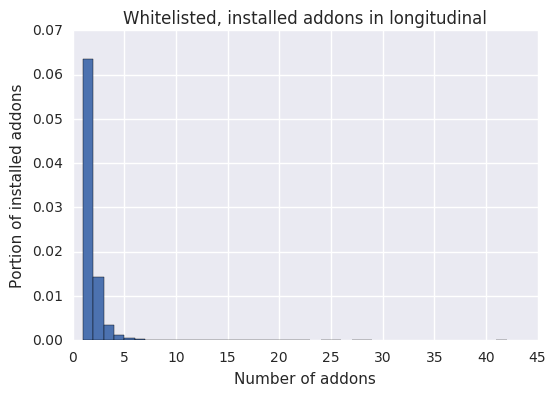

In [191]:
x, y = zip(*installed_addons_by_user)
plt.bar(x, y, width=1.)
plt.title("Whitelisted, installed addons in longitudinal")
plt.xlabel("Number of addons")
plt.ylabel("Portion of installed addons")

### Focusing on users that have no whitelisted addons installed

In [171]:
users_without_webextensions = rdd_completed\
    .filter(lambda client: len(whitelist_filter(client['installed_addons'])) == 0)

Users with no whitelisted addons generally have a lot of other addons installed.

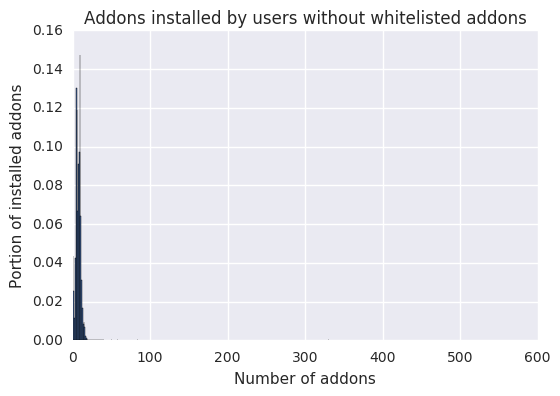

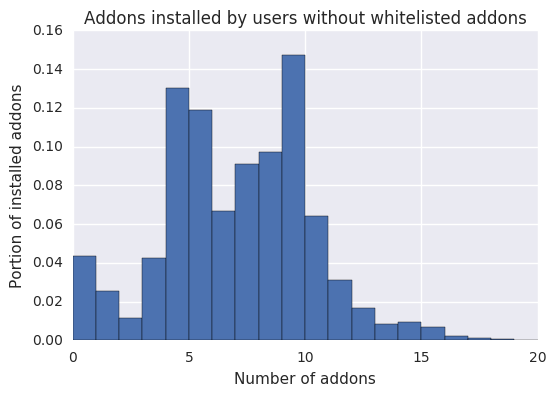

In [194]:
installed_addons_by_user = users_without_webextensions\
    .map(itemgetter('installed_addons'))\
    .map(len)

addon_counts = installed_addons_by_user\
    .map(lambda x: (x, 1))\
    .reduceByKey(add)\
    .map(make_count_relative)
    
x, y = zip(*addon_counts.collect())
plt.bar(x, y, width=1.)
plt.title("Addons installed by users without whitelisted addons")
plt.xlabel("Number of addons")
plt.ylabel("Portion of installed addons")
plt.show()

addon_counts_restricted = addon_counts\
    .filter(lambda (num_installed_addons, _): num_installed_addons < 20)\
    
x, y = zip(*addon_counts_restricted.collect())
plt.bar(x, y, width=1.)
plt.title("Addons installed by users without whitelisted addons")
plt.xlabel("Number of addons")
plt.ylabel("Portion of installed addons")
plt.show()

Most of these addons are from Mozilla, as shown in the previous section. By filtering for addons that are part of the AMO dump, we get a distribution that's similar to the one we've seen before.

This means that these users have a normal number of legacy addons installed.

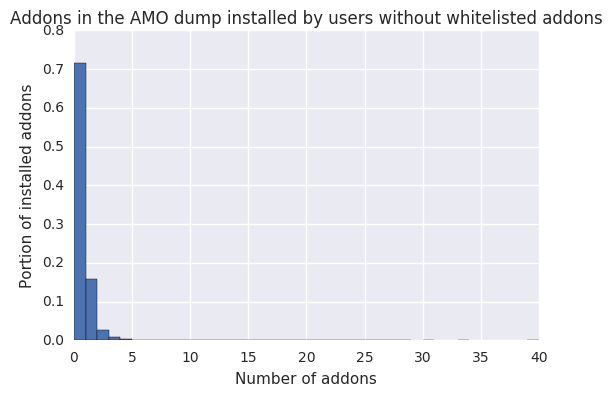

In [195]:
installed_addons_by_user = users_without_webextensions\
    .map(itemgetter('installed_addons'))\
    .map(lambda addons: [addon for addon in addons if addon in amo_dump])\
    .map(len)

addon_counts = installed_addons_by_user\
    .map(lambda x: (x, 1))\
    .reduceByKey(add)\
    .map(make_count_relative)
    
x, y = zip(*addon_counts.collect())
plt.bar(x, y, width=1.)
plt.title("Addons in the AMO dump installed by users without whitelisted addons")
plt.xlabel("Number of addons")
plt.ylabel("Portion of installed addons")
plt.show()